## look at AF spectra differences between pc and eqtls

pcqtls tend to be lower allele frequency than eqlts

this is true for middle and last pcs, not so much for 1st pcs

TODO: group this around signals to avoid double counting?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
import ast
import re
from scipy.stats import linregress
import upsetplot as up



from tqdm.auto import tqdm  # for notebooks

import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
from notebook_helper_functions import *
from annotate_clusters import *

# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [2]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/proteincoding_main.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)


# load in the tissue ids 
tissue_df = load_tissue_df(config)
tissue_ids = load_tissue_ids(config)

#tissue_ids = ['Adipose_Subcutaneous']
tissue_ids = tissue_ids[:11]

#### load in data

In [3]:
pcqtls = [load_pc_cis(config, tissue_id) for tissue_id in tissue_ids]
pcqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(pcqtls, tissue_ids)])

eqtls = [load_e_cis(config, tissue_id) for tissue_id in tissue_ids]
eqtls = pd.concat([df.assign(tissue_id=n) for df, n in zip(eqtls, tissue_ids)])

qtls = pd.concat([pcqtls, eqtls]).reset_index()
qtls = qtls[qtls['qval'] < .05]
qtls['type'] = np.where(qtls['phenotype_id'].str.contains('pc'), 'pcqtl', 'eqtl')

In [4]:
# create overlap columns
def shared_lead_var(row, qtl_df):
    matched_cluster_df = qtl_df[qtl_df['cluster_id']==row.cluster_id]
    shared_qtls = matched_cluster_df[matched_cluster_df['variant_id'] == row['variant_id']]
    #shared_qtls = shared_qtls[~(shared_qtls['phenotype_var_id']==row['phenotype_var_id'])]
    return str(shared_qtls['phenotype_id'].to_list())
    
qtls['e_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='eqtl'],))
qtls['pc_samelead'] = qtls.progress_apply(shared_lead_var, axis=1, args=(qtls[qtls['type']=='pcqtl'],))
qtls['num_e_samelead'] = qtls['e_samelead'].apply(ast.literal_eval).apply(len)
qtls['num_pc_samelead'] = qtls['pc_samelead'].apply(ast.literal_eval).apply(len)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 34901/34901 [01:20<00:00, 432.77it/s]


In [5]:
qtls['exclusive_label'] = np.where((qtls['num_e_samelead'] > 0), np.where((qtls['num_pc_samelead'] > 0), 'shared', 'eqtl_only'), 'pcqtl_only')
qtls['pc_num'] = np.where(qtls['type']=='pcqtl',  qtls['phenotype_id'].str.split('_pc').str[-1], 0)
qtls['pc_num'] = qtls['pc_num'].astype(int)
# add in cluster size
qtls['cluster_size'] = qtls['cluster_id'].str.split('_').apply(len)
# split first, last, and middle pcs
qtls['pc_order'] = 'middle'
qtls.loc[qtls['pc_num'] == qtls['cluster_size'],'pc_order'] = 'last'
qtls.loc[qtls['pc_num'] == 1,'pc_order'] = 'first'
qtls.loc[qtls['type'] == 'eqtl','pc_order'] = 'eqtl'

In [22]:
qtls['minor_af'] = np.where(qtls['af']>.5, 1-qtls['af'], qtls['af'])
qtls_grouped = qtls.groupby(['variant_id', 'tissue_id', 'cluster_id']).agg({'phenotype_id':list, 'minor_af':'first', 'exclusive_label':'first'})


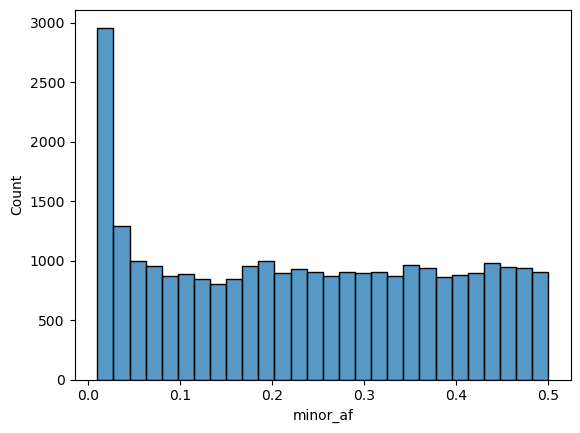

In [23]:
sns.histplot(qtls_grouped, x='minor_af')
plt.show()

<AxesSubplot: xlabel='minor_af', ylabel='Proportion'>

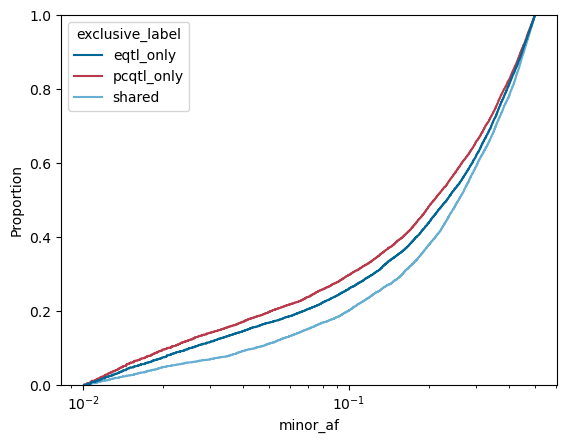

In [24]:
sns.ecdfplot(data=qtls_grouped, x='minor_af', hue='exclusive_label', stat="proportion", log_scale=True, 
             palette={'pcqtl_only':'#B83A4B', 'eqtl_only':'#016895', 'shared':'#67AFD2'})


<AxesSubplot: xlabel='minor_af', ylabel='Proportion'>

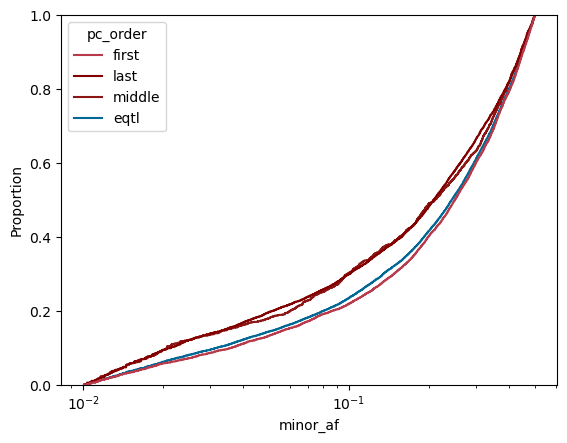

In [29]:
sns.ecdfplot(data=qtls, x='minor_af', hue='pc_order', stat="proportion", log_scale=True, 
             palette={'first':'#B83A4B', 'middle':'#8C1515', 'last':'#820000', 'eqtl':'#016895'})